# Image Generation Experiments

### Table of Contents
1. [Exp 1: Pre-processing the provided Depth-Maps and Generating Images](#1.-pre-processing-the-provided-depth-maps-and-generating-images)
2. [Exp 2: Testing different controls with `MultiControlNet`](#2.-testing-different-controls-with-multicontrolnet)
3. [Comparison with the depth-only baseline](#comparison-with-the-depth-only-baseline)
4. [Takeaways](#takeaways)

In this notebook, I experimented with image generation using the `SD1.5 + ControlNet` models and ComfyUI. The goal was to generate the "best" images from the standardized depth maps. Here, my strategy was to establish a baseline for all the inputs, which I would then compare with the outputs for multiple controls or conditions. To do this, I up/down-scaled the input depth-maps to 512x512 using `nearest-exact` interpolation first. This was done primarily to allow metric computation between the generated and input depth-maps, but this also has additional quality benefits. Apart from this, the simplest way to produce better results in generative AI is to add rich context to the input prompts. As I cannot modify the given prompts for this assignment, my options were limited. I considered using a language model to automatically expand on the short prompts, but decided against it due to the increase in computational cost, and as the results may not be reproducible. However, I added a simple fix here, which was to incorporate a detailed list of _negative_ prompts as a heuristic, which I kept **constant** for all inputs.

* Negative prompts used: `blurry, blurred, grainy, low resolution, dark, overexposed, underexposed, distorted, cluttered, uninviting, plain, cheap, unrealistic, artifacts, dull, hazy, low contrast, cramped, empty`.

Below is an ordered list of the experiments I conducted. Note that, there are sub-experiments within each experiment, which will be detailed in the respective sections.

1. DM ➡️ PREPROCESS (i.e., Up/down-scale to 512x512 + Negative Prompts) ➡️ GENERATE ➡️ METRICS (i.e, visually + NRMSE + SSIM + PSNR between generated and base depthmaps + MANIQA for the generated image)
    1. DM ➡️ PREPROCESS + Resize latents ➡️ GENERATE ➡️ METRICS
2. DM ➡️ PREPROCESS ➡️ `MultiControlNet` ➡️ GENERATE ➡️ METRICS
    1. Tiling: `control_v11f1e_sd15_tile`
    2. Normals: BAE - `control_v11p_sd15_normalbae`
    3. Edge: TEED, Canny, M-LSD - `control_v11f1p_sd15_softedge`, `control_v11f1p_sd15_canny`, `control_v11f1p_sd15_mlsd`
    4. Segmentation: SAM, OFADE20K - `control_v11f1p_sd15_seg`, `control_v11f1p_sd15_segofade`
    5. Depth: MiDaS, DA, DAv2 - `control_v11f1p_sd15_depth`, `control_v11f1p_sd15_depthda`, `control_v11f1p_sd15_depthv2`

My criteria for "best" image is based on the following:
1. The Depth-Maps are adhered to as much as possible.
2. The generated images are visually appealing and follow the prompts.
3. The generated images do not have uncanny artifacts or disconnected components.
4. The generated images are sharp and detailed (as much as possible with `512x512` - Tiling helps here).

> _As we shall see below, there is a trade-off between the quality of the generated images and adherence to the provided controls_.

### Limitations
* MANIQA is susceptible to the input resolution. It is not a perfect metric, but does provide general trends.
* ComfyUI is fantastic for iterations but fails at providing ways to batch experiments to obtain useful statistics. This slowed down my testing by a lot and I had to cut out some of the planned experiments, such as `Img2Img` using the generated image & controls.

In [8]:
import json
import numpy as np
from rich import print
from rich.table import Table
from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image

# Local imports
from utils import create_table

# `create_table` is a function that creates a table of metrics and saves them to a .json file

exp_root = Path("./results/1_experiments")

## 1. Pre-processing the provided Depth-Maps and Generating Images
* The pre-processing steps include:
    * Up/down-scaling the depth-maps to 512x512
    * Adding negative prompts
* I also tested the effect of matching the latent-size (default: `512x512`) to the image-size (between `168x168` to `2668x2668`).
* The associated ComfyUI workflow is available [here](./workflows/1_experiments/1_experiments_exp1_workflow.json) (`./workflows/1_experiments_exp1_workflow.json`).

<h4>Exp 1: ComfyUI Workflow</h4>
<img src="./workflows/1_experiments/1_experiments_exp1_workflow.png" width="80%" alt="ComfyUI Workflow for Exp 1">


                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp1_1_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.515     │      0.595       │ 0.959  │
│ SSIM ↑  │     0.841     │      0.854       │ 0.570  │
│ PSNR ↑  │    18.051     │      16.797      │ 12.656 │
│MANIQA ↑ │                   0.594                   │
└─────────┴───────────────────────────────────────────┘

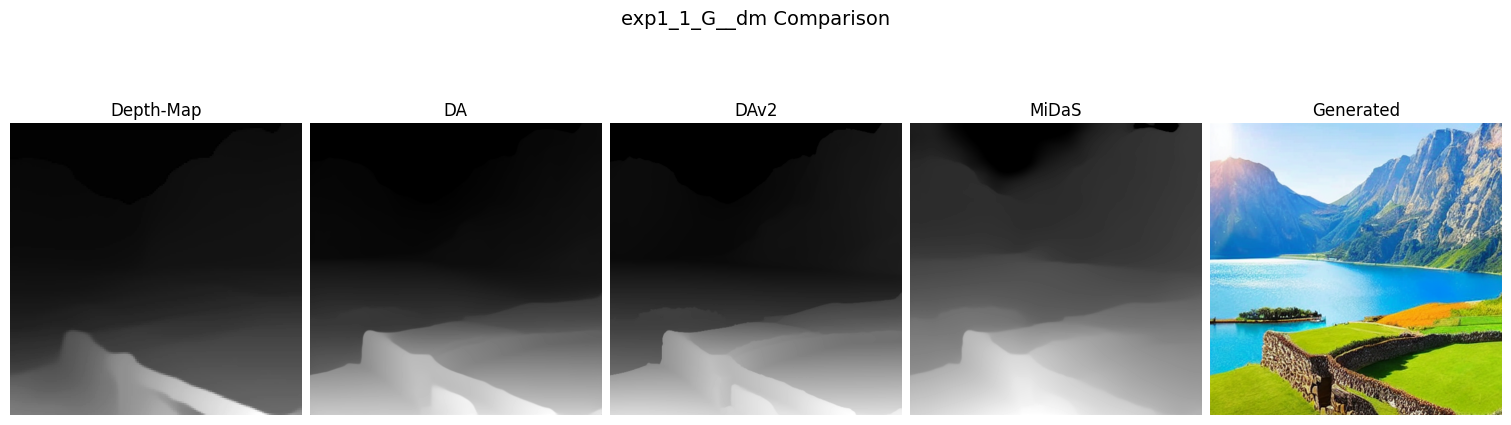

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp1_2_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.560     │      0.426       │ 0.290  │
│ SSIM ↑  │     0.608     │      0.654       │ 0.726  │
│ PSNR ↑  │    11.750     │      14.112      │ 17.447 │
│MANIQA ↑ │                   0.618                   │
└─────────┴───────────────────────────────────────────┘

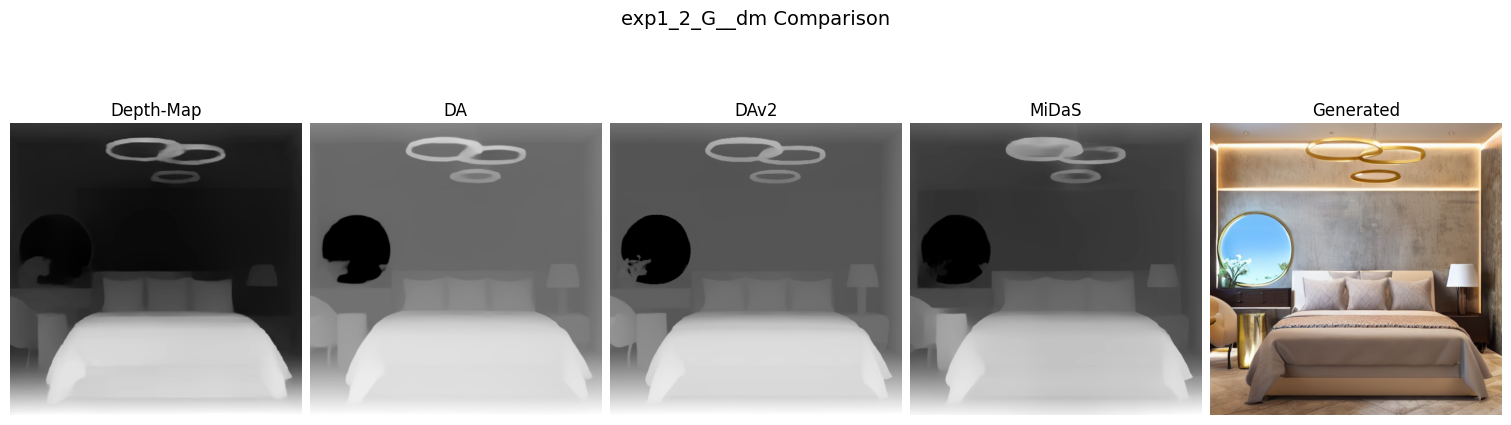

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp1_3_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.464     │      0.174       │ 0.190  │
│ SSIM ↑  │     0.350     │      0.479       │ 0.676  │
│ PSNR ↑  │    13.167     │      21.709      │ 20.906 │
│MANIQA ↑ │                   0.492                   │
└─────────┴───────────────────────────────────────────┘

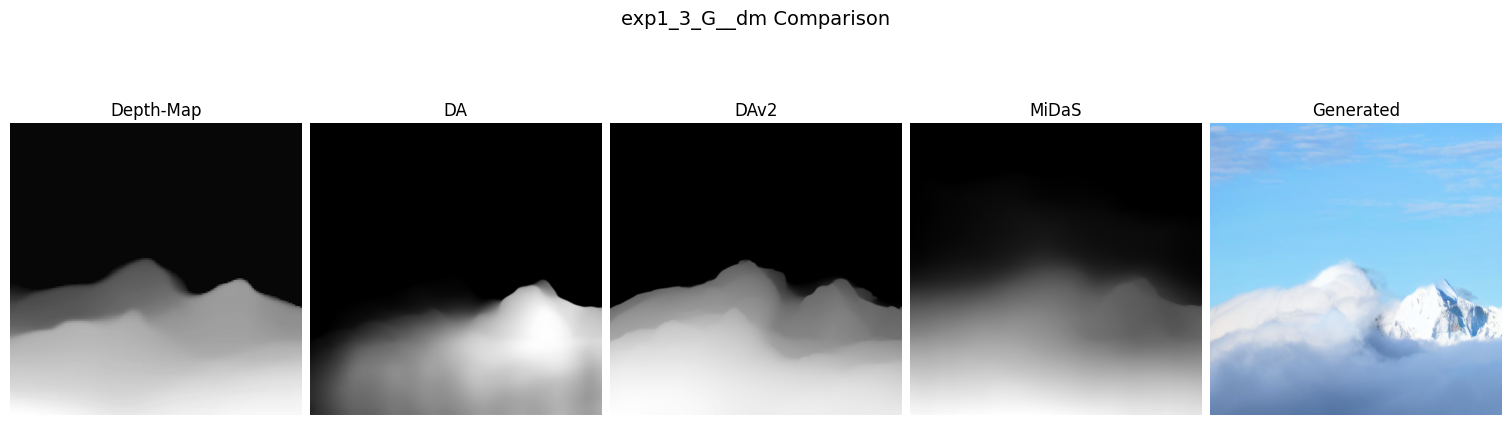

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp1_4_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.111     │      0.137       │ 0.147  │
│ SSIM ↑  │     0.807     │      0.698       │ 0.787  │
│ PSNR ↑  │    28.100     │      26.269      │ 25.657 │
│MANIQA ↑ │                   0.683                   │
└─────────┴───────────────────────────────────────────┘

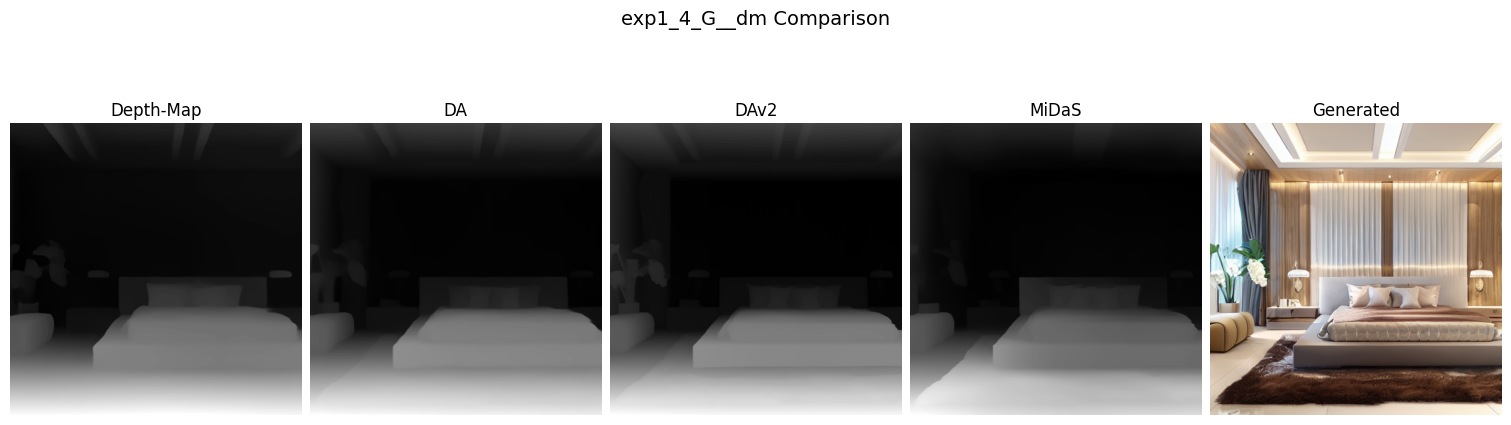

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp1_5_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.765     │      0.626       │ 0.688  │
│ SSIM ↑  │     0.189     │      0.209       │ 0.190  │
│ PSNR ↑  │    10.620     │      12.371      │ 11.541 │
│MANIQA ↑ │                   0.668                   │
└─────────┴───────────────────────────────────────────┘

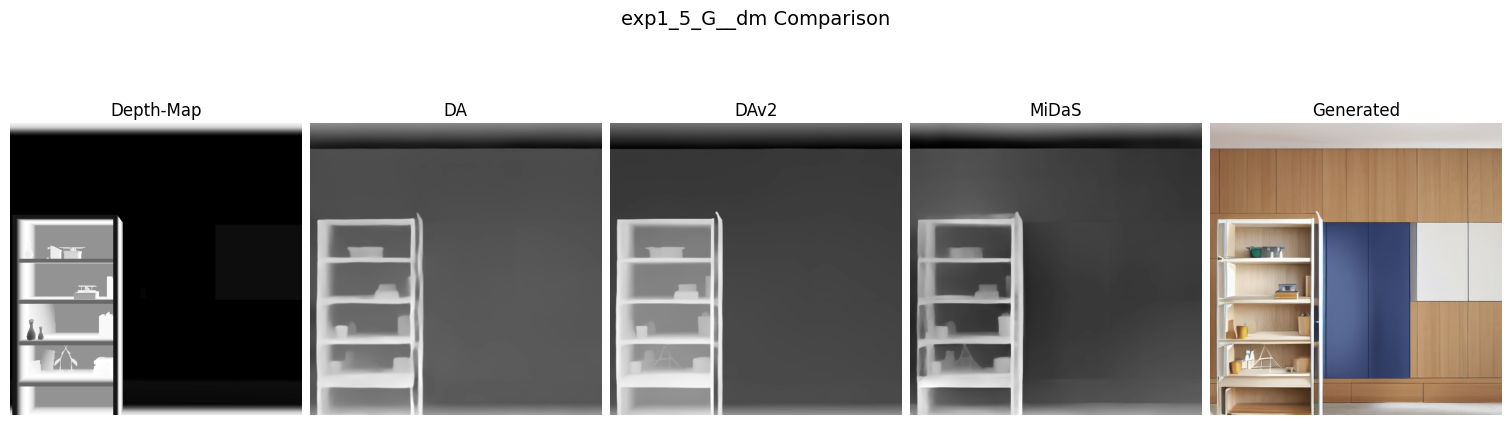

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp1_6_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.360     │      0.347       │ 0.382  │
│ SSIM ↑  │     0.790     │      0.807       │ 0.778  │
│ PSNR ↑  │    13.603     │      13.940      │ 13.098 │
│MANIQA ↑ │                   0.837                   │
└─────────┴───────────────────────────────────────────┘

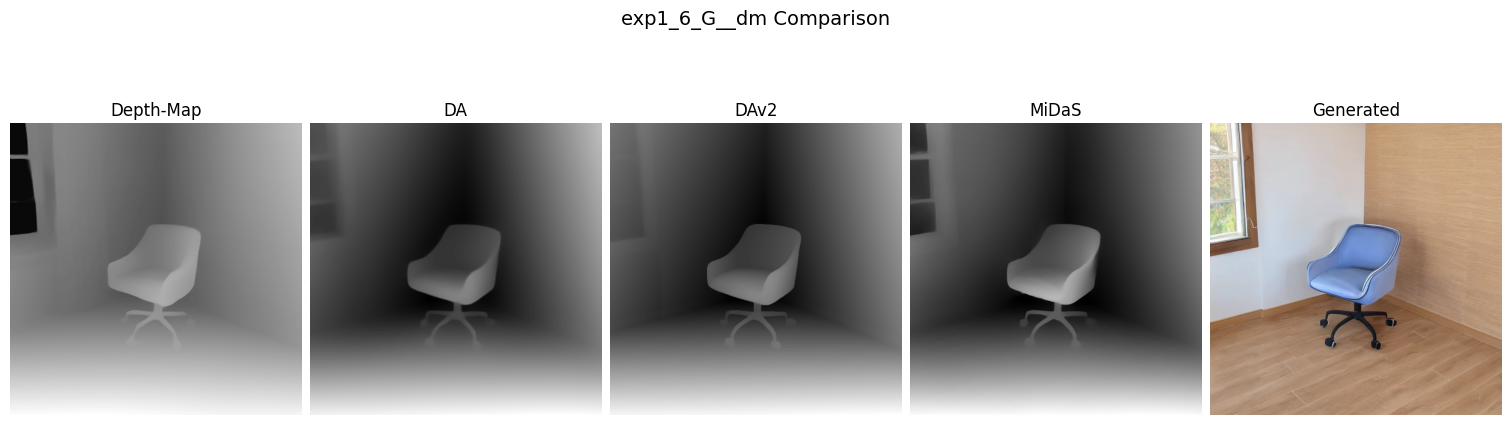

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp1_7_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.207     │      0.164       │ 0.181  │
│ SSIM ↑  │     0.844     │      0.905       │ 0.923  │
│ PSNR ↑  │    21.337     │      23.326      │ 22.492 │
│MANIQA ↑ │                   0.764                   │
└─────────┴───────────────────────────────────────────┘

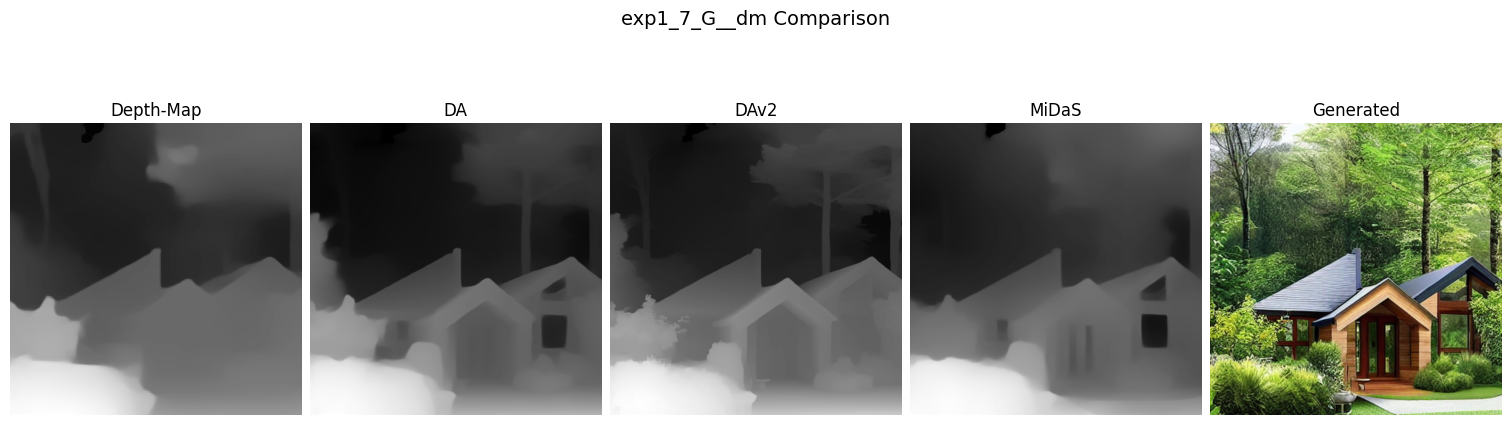

In [9]:
# Visualizing results
exp_name = "exp1"
exp_path = exp_root / exp_name
save_path = exp_path / "results"
save_path.mkdir(exist_ok=True)

res = list(exp_path.glob(f"{exp_name}*.png"))
res.sort()

step = 5
da = res[0::step]
dav2 = res[1::step]
dms = res[2::step]  # Up-scaled base depth-maps
gen = res[3::step]  # Generated images
midas = res[4::step]

# dms, da, dav2, midas, gen = map(lambda x: list(map(lambda y: Image.open(y), x)), (dms, da, dav2, midas, gen))

for i, dm in enumerate(dms):
    dm_stem = dm.stem

    dm_img = Image.open(dm).convert("L")
    da_img = Image.open(da[i]).convert("L")
    dav2_img = Image.open(dav2[i]).convert("L")
    midas_img = Image.open(midas[i]).convert("L")
    gen_img = Image.open(gen[i])

    # Create table & save results to json
    met_table = create_table(
        dm_img,
        [da_img, dav2_img, midas_img],
        gen_img,
        dm_stem,
        json_path=save_path / f"{dm_stem}_metrics.json",
    )

    print(met_table)

    # Plot images
    fig, axs = plt.subplots(1, 5, figsize=(15, 5), constrained_layout=True)
    fig.suptitle(f"{dm_stem} Comparison", fontsize=14)

    axs[0].imshow(dm_img, cmap="gray")
    axs[0].set_title("Depth-Map")
    axs[0].axis("off")

    axs[1].imshow(da_img, cmap="gray")
    axs[1].set_title("DA")
    axs[1].axis("off")

    axs[2].imshow(dav2_img, cmap="gray")
    axs[2].set_title("DAv2")
    axs[2].axis("off")

    axs[3].imshow(midas_img, cmap="gray")
    axs[3].set_title("MiDaS")
    axs[3].axis("off")

    axs[4].imshow(gen_img)
    axs[4].set_title("Generated")
    axs[4].axis("off")

    # Save image to file
    plt.savefig(save_path / f"{dm_stem}_comparison.png", bbox_inches="tight")

    plt.show()
    plt.close()

### 1.1 Testing effect of matching latent-image size to input depth-map size:
* For this, I picked `1_G.png` (`168x168`), and `4_G.png` (`2668x2668`), as they represent the extremes in the dataset.
* The latent image size was set to `512x512` by default, but here, I reset it to match the input depth-map size.
* The associated ComfyUI workflow is available [here](./workflows/1_experiments/1_experiments_exp1.1_workflow.json) (`./workflows/1_experiments_exp1.1_workflow.json`).
* The generated image for `1_G.png` is below, while that for `4_G.png` can be found in [this folder](./workflows/1_experiments/) (the image is quite large).

<h4>Exp 1.1: ComfyUI Workflow</h4>
<img src="./workflows/1_experiments/1_experiments_exp1.1_workflow.png" width="80%" alt="ComfyUI Workflow for Exp 1.1">
<img src="./workflows/1_experiments/1_experiments_exp1_latents_1_G.png" width="30%" alt="Effect of matching latent size for 1_G.png">
<!-- <img src="./workflows/1_experiments/1_experiments_exp1_latents_4_G.png" width="auto" alt="Effect of matching latent size for 4_G.png"> -->

From the images, it is clear that, changing the latent size adversely affects the generation process, which is expected, as the base models are trained on `512x512` latent images. Large latent sizes also impact the generation time and VRAM usage - for `4_G.png`, the VRAM usage was `8.7 GB`, and the generation time was `132.24s`, as opposed to ~`3 GB` and `1.55s` for the default latent size.

## 2. Testing different controls with `MultiControlNet`
As mentioned above, the following controls were tested (Depth Control was always enabled with `strength=1.0`):
    1. Tiling: `control_v11f1e_sd15_tile`
    2. Normals: BAE - `control_v11p_sd15_normalbae`
    3. Segmentation: OFADE20K - `control_v11f1p_sd15_seg`
    4. SoftEdge: TEED - `control_v11f1p_sd15_softedge`
    5. Canny: `control_v11f1p_sd15_canny`
    6. M-LSD: `control_v11f1p_sd15_mlsd`

Given the variety of the scenes in the provided depth-maps (indoor, nature, etc.), I first ran the aforementioned controls ("pre-processors") and based on their outputs, I decided to enable them and experiment with them, using ComfyUI's `MultiControlNet` node. I expected that specific controls would work better for specific scenes, e.g., for the indoor scenes, line and edge detection models should boost the generated image quality, while for nature scenes, tiling and segmentation should work better. This was easily verified in my testing, as presented below.

<h4>Exp 2: ComfyUI Workflow (added to Exp 1's workflow)</h4>
<img src="./workflows/1_experiments/1_experiments_exp2_workflow.png" width="80%" alt="ComfyUI Workflow for Exp 2 (added to Exp 1's workflow)">

The associated workflow is available at [`./workflows/1_experiments/1_experiments_exp2_workflow.json`](./workflows/1_experiments/1_experiments_exp2_workflow.json).

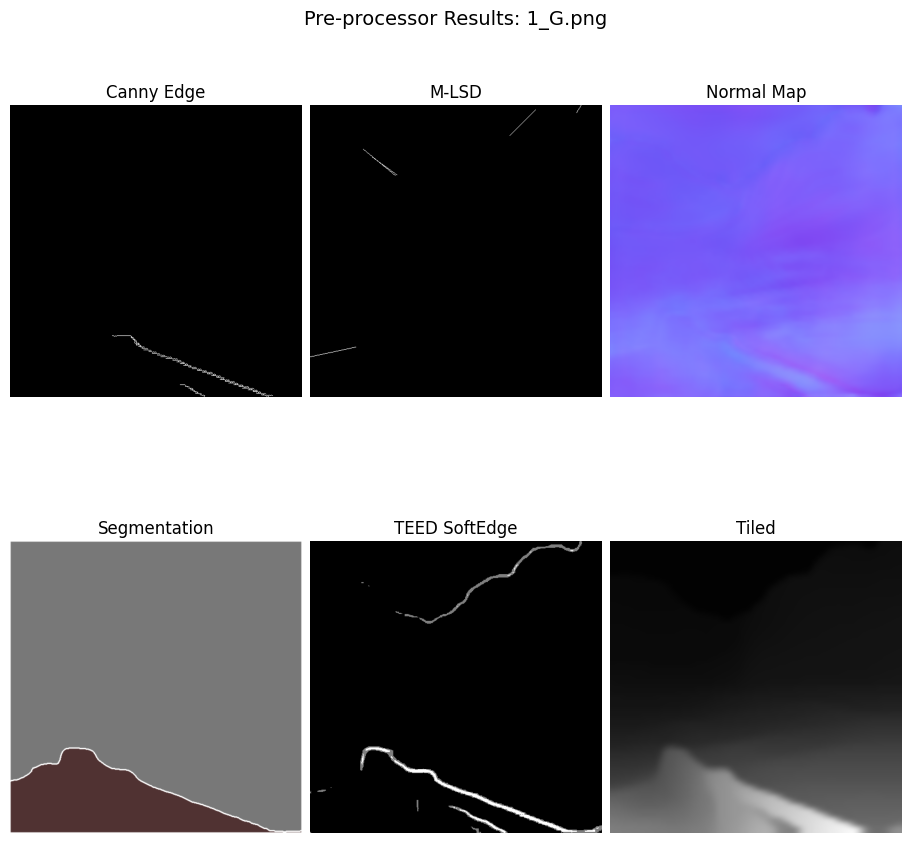

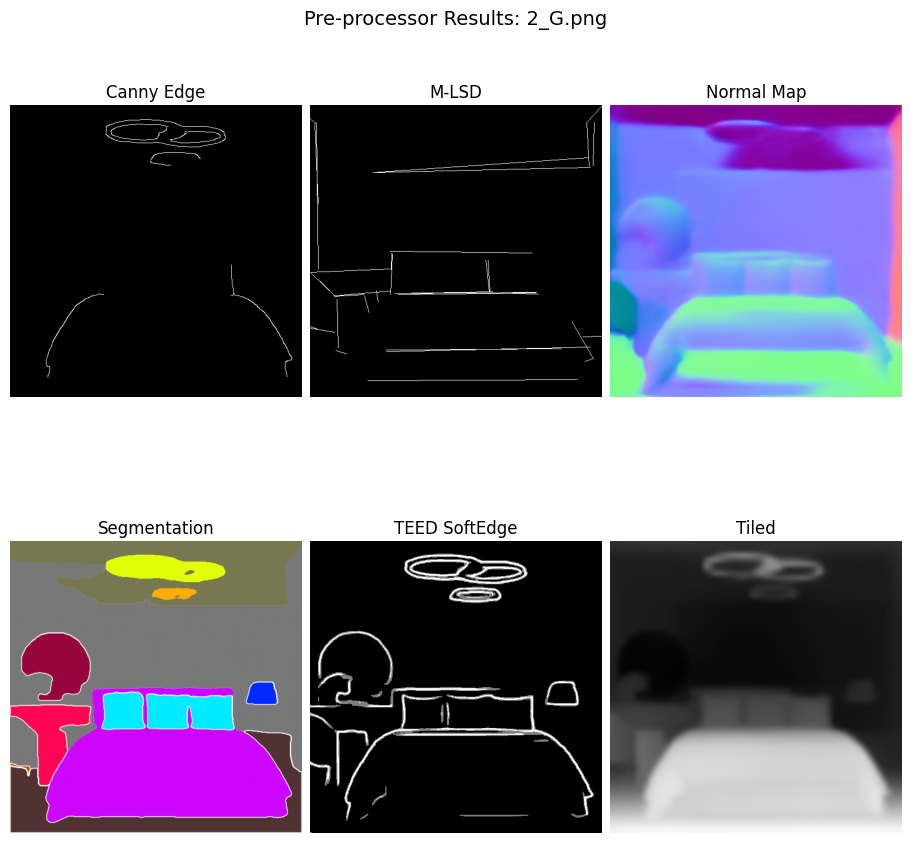

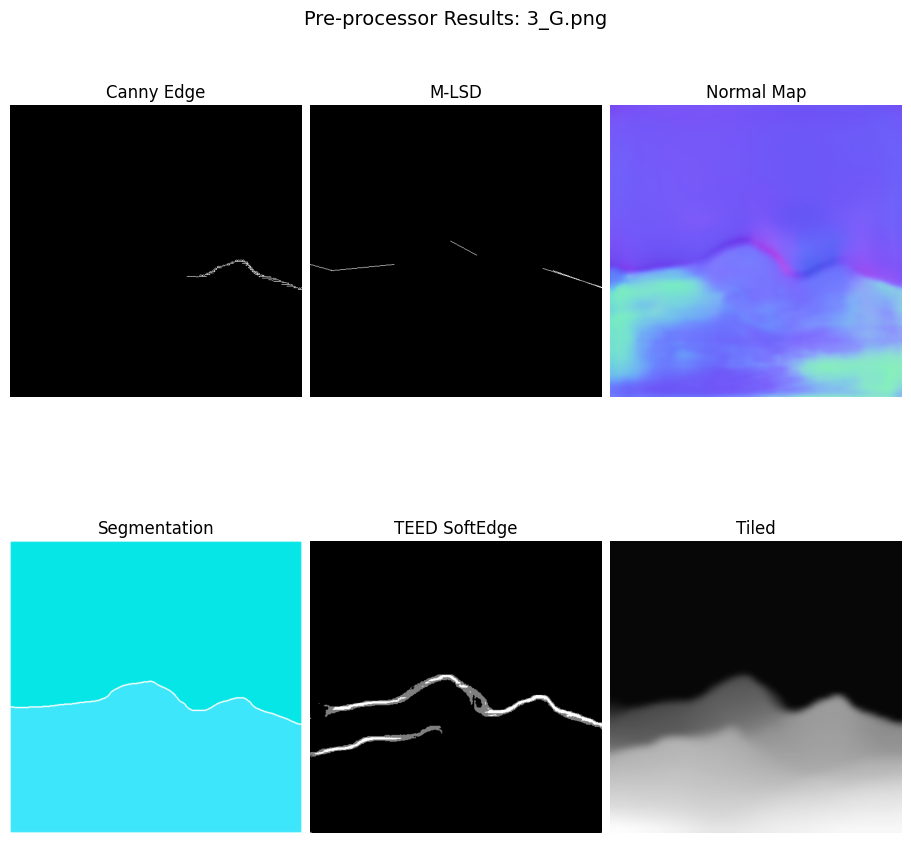

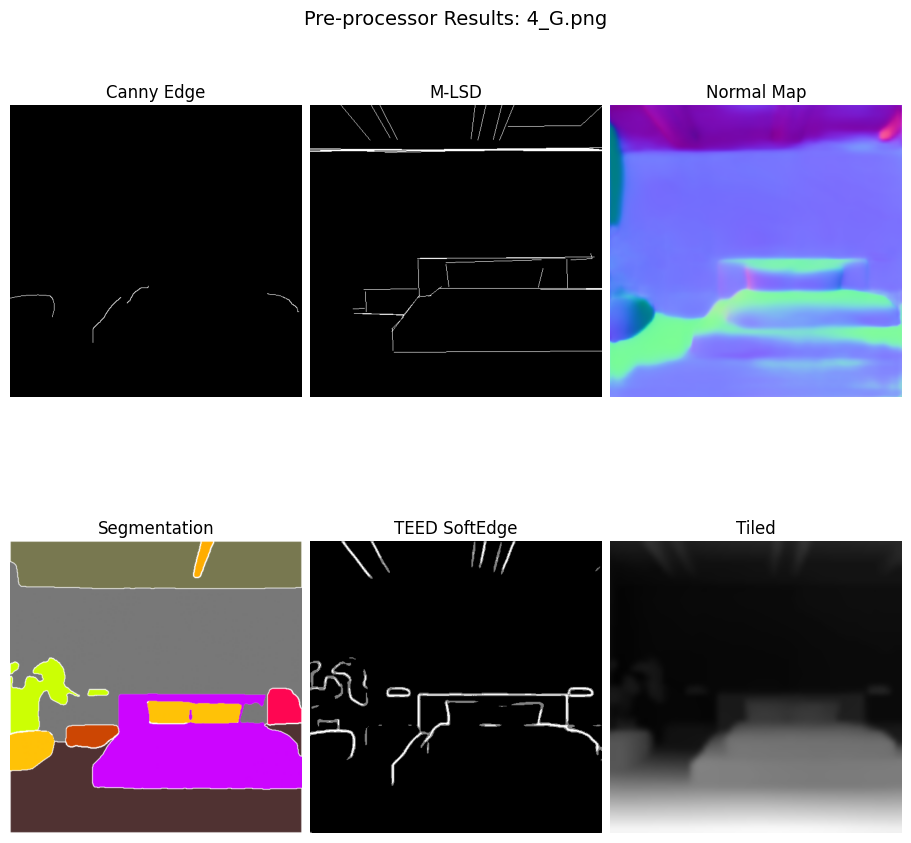

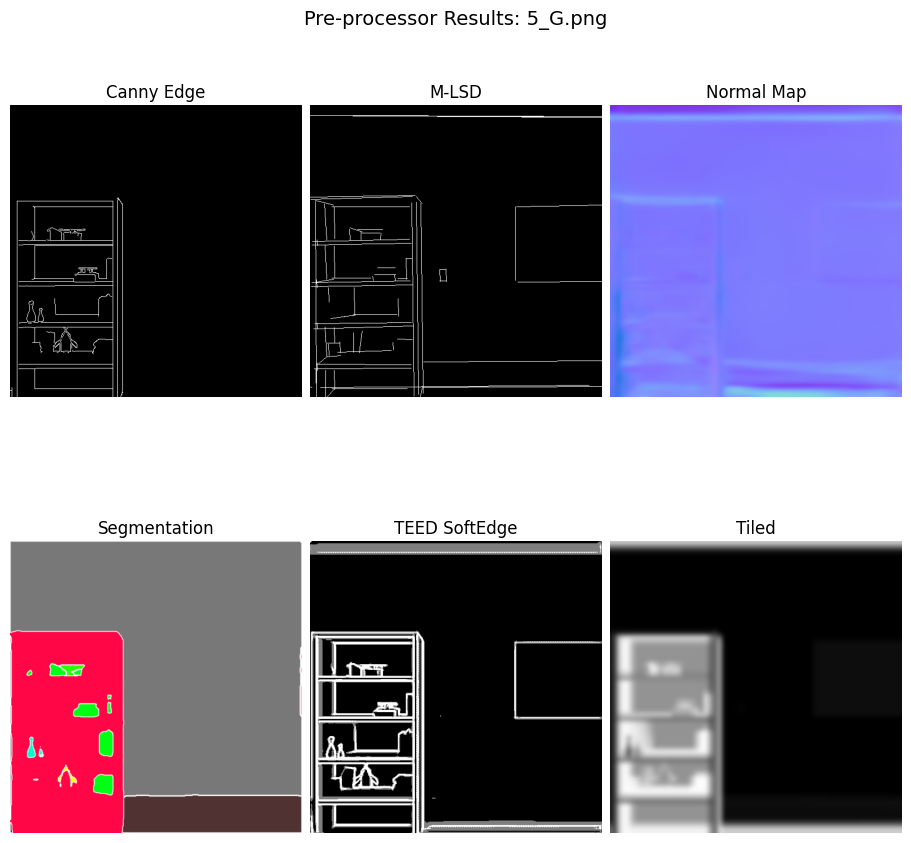

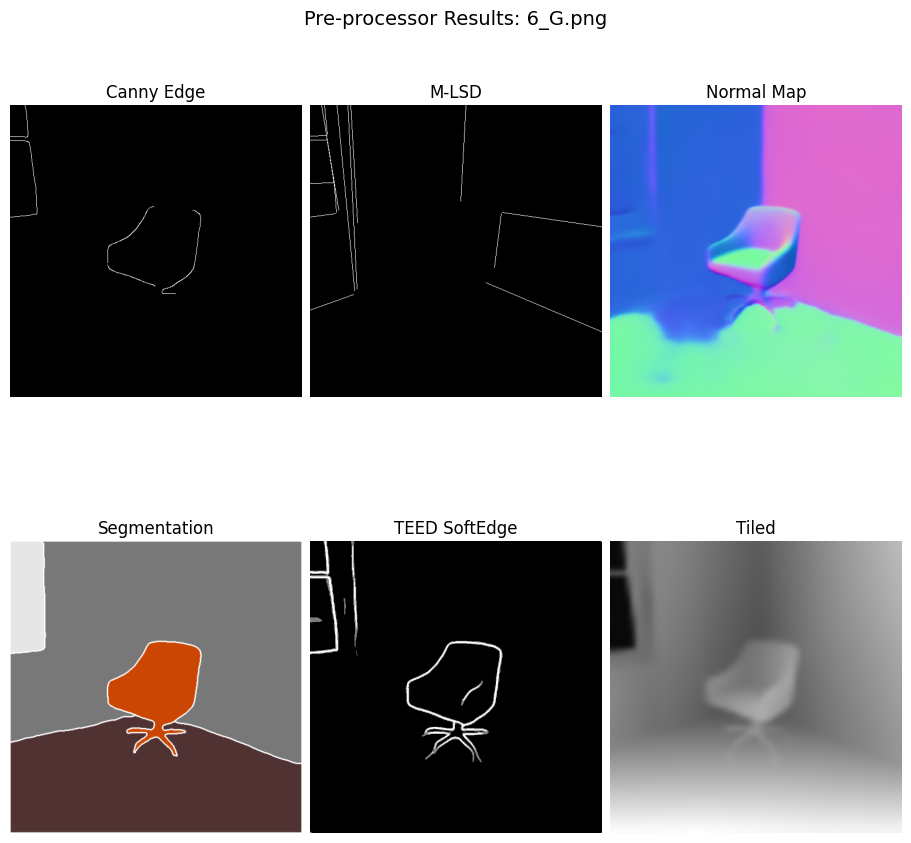

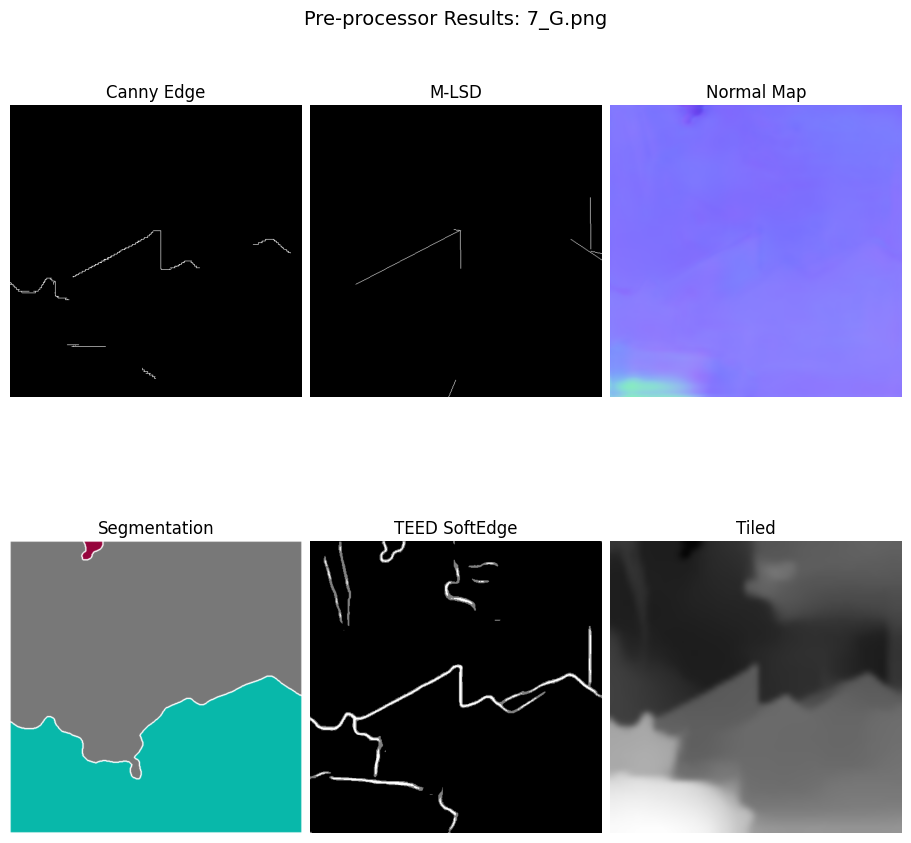

In [10]:
# Visualizing results
exp_name = "exp2"
exp_path = exp_root / exp_name / "controls"
save_path = exp_path / "results"
save_path.mkdir(exist_ok=True)

res = list(exp_path.glob(f"{exp_name}*.png"))
res.sort()

step = 6
canny = res[0::step]
mlsd = res[1::step]
norm = res[2::step]
seg = res[3::step]
teed = res[4::step]
tile = res[5::step]

# Visualize in a grid of 2x3
for i, (canny_img, mlsd_img, norm_img, seg_img, teed_img, tile_img) in enumerate(
    zip(canny, mlsd, norm, seg, teed, tile)
):
    canny_img = Image.open(canny_img)
    mlsd_img = Image.open(mlsd_img)
    norm_img = Image.open(norm_img)
    seg_img = Image.open(seg_img)
    teed_img = Image.open(teed_img)
    tile_img = Image.open(tile_img)

    # Plot images
    fig, axs = plt.subplots(2, 3, figsize=(9, 9), constrained_layout=True)
    fig.suptitle(f"Pre-processor Results: {i + 1}_G.png", fontsize=14)

    axs[0, 0].imshow(canny_img)
    axs[0, 0].set_title("Canny Edge")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(mlsd_img)
    axs[0, 1].set_title("M-LSD")
    axs[0, 1].axis("off")

    axs[0, 2].imshow(norm_img)
    axs[0, 2].set_title("Normal Map")
    axs[0, 2].axis("off")

    axs[1, 0].imshow(seg_img)
    axs[1, 0].set_title("Segmentation")
    axs[1, 0].axis("off")

    axs[1, 1].imshow(teed_img)
    axs[1, 1].set_title("TEED SoftEdge")
    axs[1, 1].axis("off")

    axs[1, 2].imshow(tile_img)
    axs[1, 2].set_title("Tiled")
    axs[1, 2].axis("off")

    # Save image to file
    plt.savefig(
        save_path / f"{i + 1}_G_preprocessor_comparison.png", bbox_inches="tight"
    )

    plt.show()
    plt.close()

Given the outputs from the preprocessors, I used the following controls, per image, with their strength values given in parentheses (they were determined empirically):
* `1_G.png`: Tiling(0.2), SoftEdge(0.75)
* `2_G.png`: Tiling(0.2), Segmentation(0.75), Normal(0.3), SoftEdge(0.6), M-LSD(0.3)
* `3_G.png`: Tiling(0.2), Segmentation(0.5), SoftEdge(0.5)
* `4_G.png`: Tiling(0.2), Segmentation(0.75), SoftEdge(0.5)
* `5_G.png`: Tiling(0.2), Segmentation(0.75), Normal(0.5), SoftEdge(0.5), Canny(0.5), M-LSD(0.3)
* `6_G.png`: Tiling(0.2), Normal(0.5)
* `7_G.png`: Tiling(0.2), Segmentation(0.75)

The outcomes are presented below:

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp2_1_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.476     │      0.455       │ 0.426  │
│ SSIM ↑  │     0.563     │      0.703       │ 0.793  │
│ PSNR ↑  │    16.439     │      16.826      │ 17.408 │
│MANIQA ↑ │                   0.833                   │
└─────────┴───────────────────────────────────────────┘

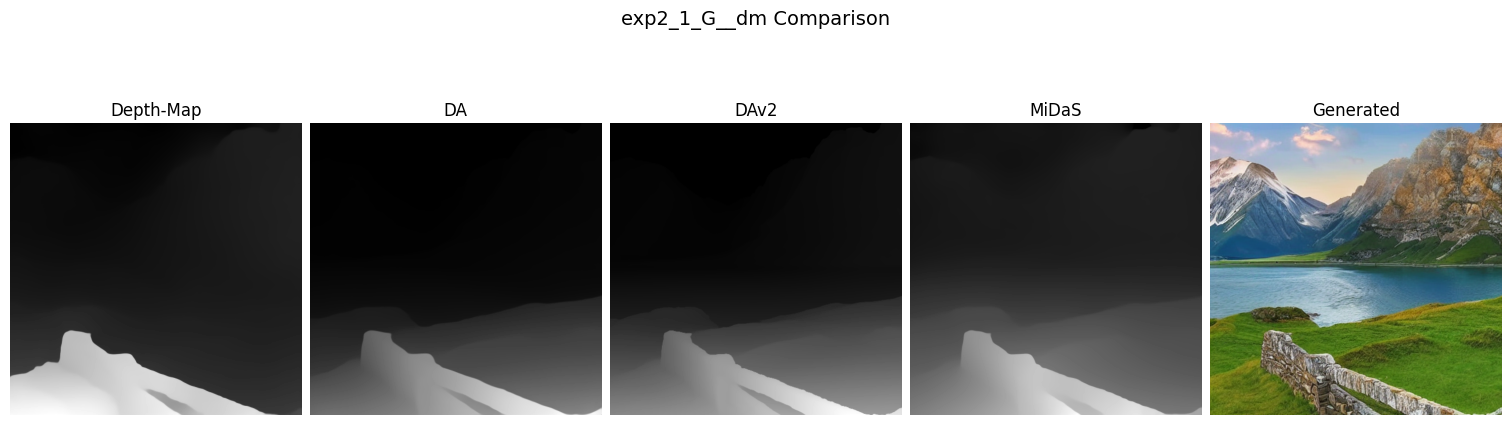

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp2_2_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.366     │      0.210       │ 0.102  │
│ SSIM ↑  │     0.776     │      0.616       │ 0.971  │
│ PSNR ↑  │    16.383     │      21.221      │ 27.514 │
│MANIQA ↑ │                   0.537                   │
└─────────┴───────────────────────────────────────────┘

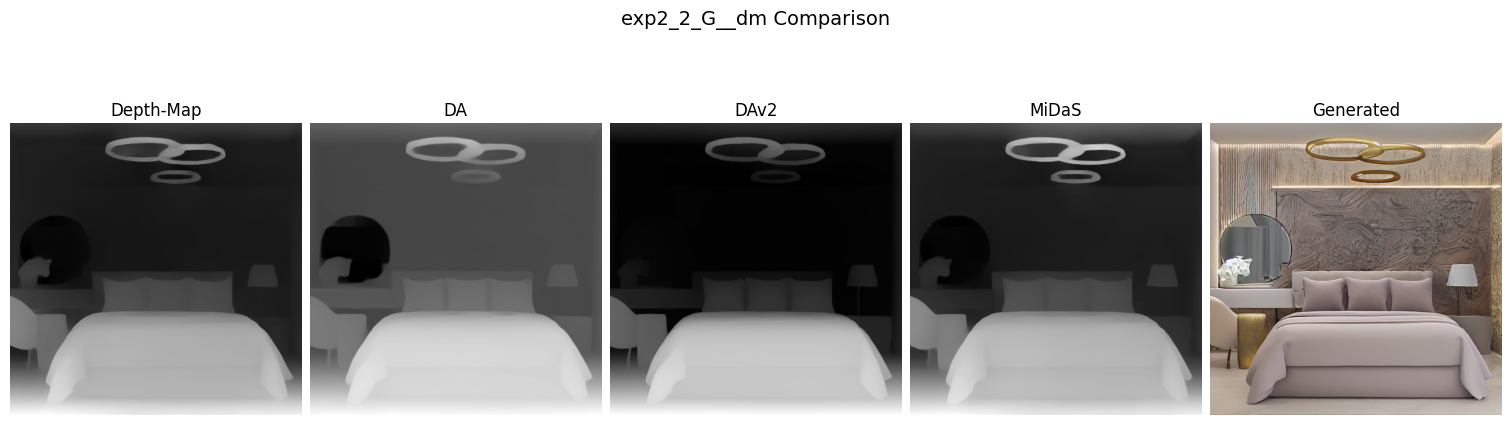

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp2_3_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.174     │      0.219       │ 0.253  │
│ SSIM ↑  │     0.917     │      0.872       │ 0.840  │
│ PSNR ↑  │    21.892     │      19.920      │ 18.658 │
│MANIQA ↑ │                   0.364                   │
└─────────┴───────────────────────────────────────────┘

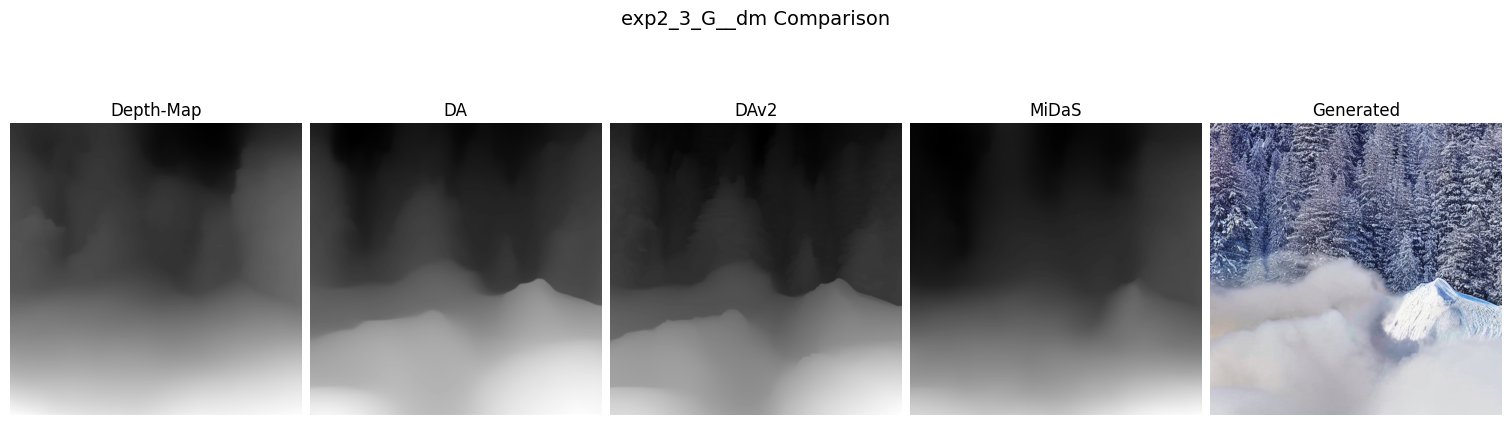

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp2_4_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.575     │      0.608       │ 0.435  │
│ SSIM ↑  │     0.870     │      0.757       │ 0.910  │
│ PSNR ↑  │    17.852     │      17.380      │ 20.281 │
│MANIQA ↑ │                   0.650                   │
└─────────┴───────────────────────────────────────────┘

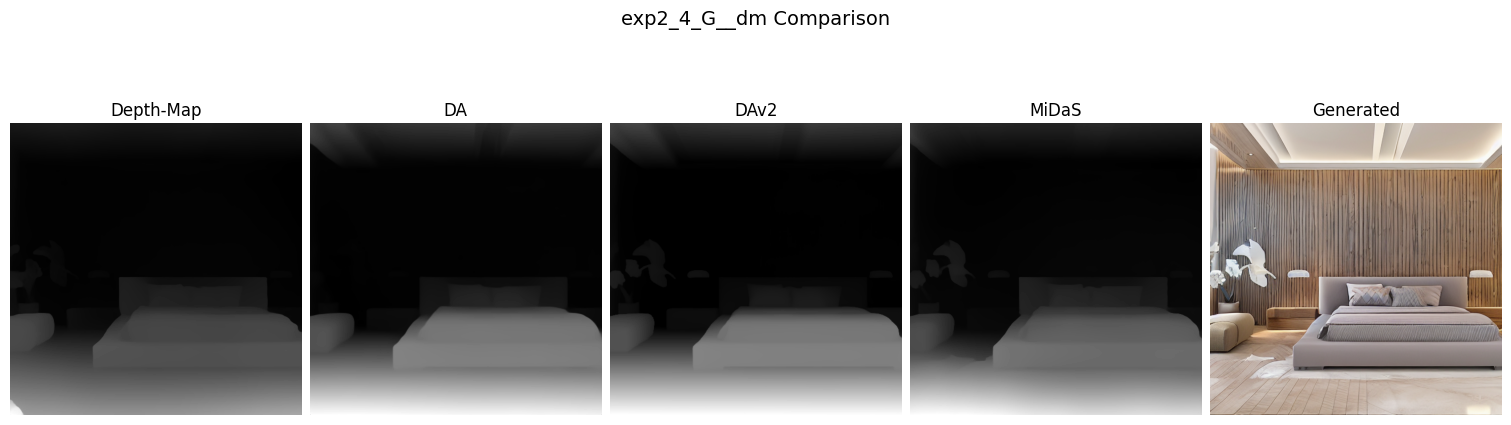

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp2_5_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.659     │      0.690       │ 0.736  │
│ SSIM ↑  │     0.233     │      0.238       │ 0.136  │
│ PSNR ↑  │    11.920     │      11.517      │ 10.955 │
│MANIQA ↑ │                   0.409                   │
└─────────┴───────────────────────────────────────────┘

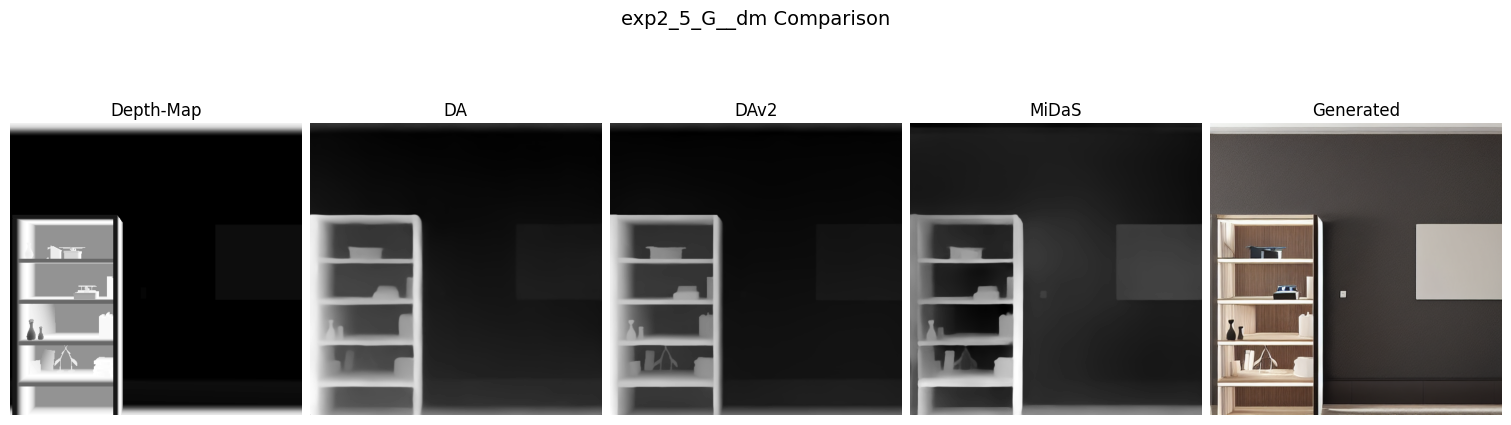

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp2_6_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.250     │      0.207       │ 0.254  │
│ SSIM ↑  │     0.870     │      0.905       │ 0.939  │
│ PSNR ↑  │    19.105     │      20.737      │ 18.954 │
│MANIQA ↑ │                   0.510                   │
└─────────┴───────────────────────────────────────────┘

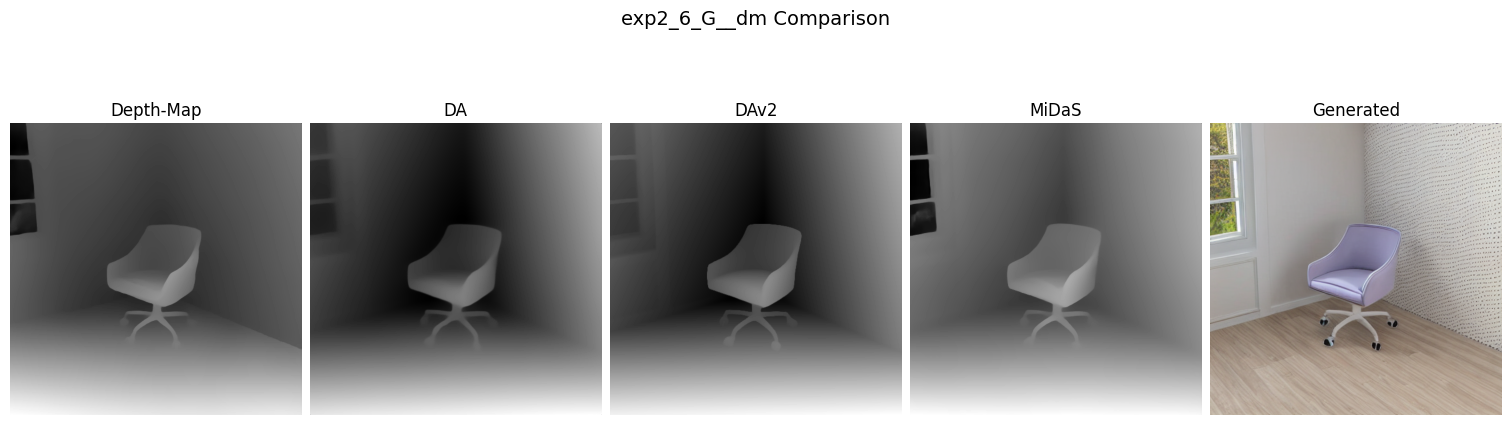

                 Quantitative Metrics                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃               exp2_7_G__dm                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DepthAnything ┃ DepthAnything v2 ┃ MiDaS  │
│━━━━━━━━━│━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━│
│ NRMSE ↓ │     0.378     │      0.232       │ 0.432  │
│ SSIM ↑  │     0.570     │      0.828       │ 0.568  │
│ PSNR ↑  │    16.097     │      20.333      │ 14.921 │
│MANIQA ↑ │                   0.814                   │
└─────────┴───────────────────────────────────────────┘

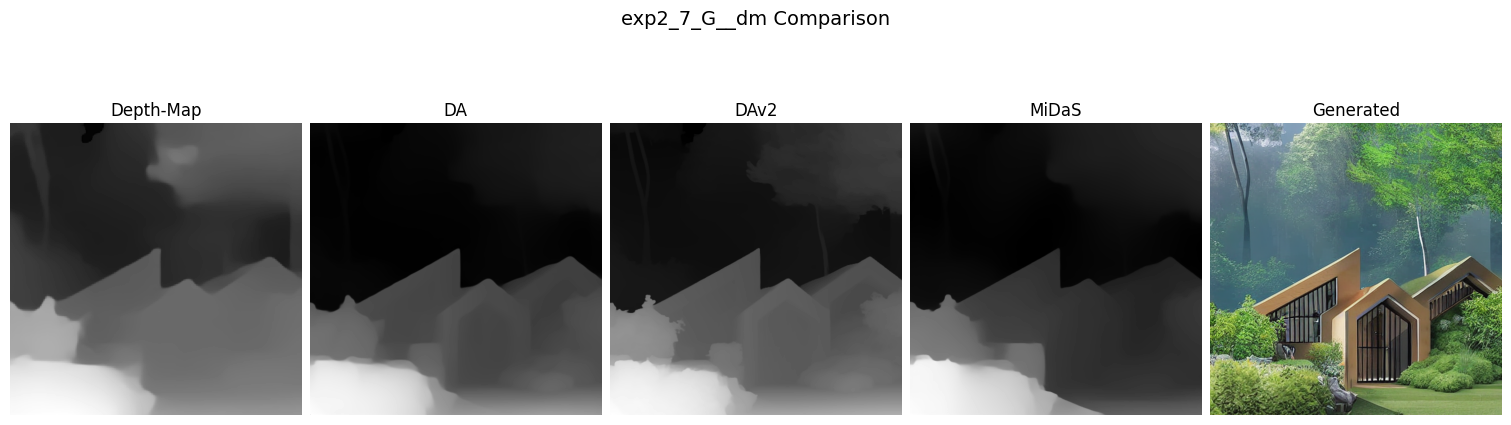

In [11]:
# Visualizing results
exp_name = "exp2"
exp_path = exp_root / exp_name
save_path = exp_path / "results"
save_path.mkdir(exist_ok=True)

res = list(exp_path.glob(f"{exp_name}*.png"))
res.sort()

step = 5
da = res[0::step]
dav2 = res[1::step]
dms = res[2::step]  # Up-scaled base depth-maps
gen = res[3::step]  # Generated images
midas = res[4::step]

for i, dm in enumerate(dms):
    dm_stem = dm.stem

    dm_img = Image.open(dm).convert("L")
    da_img = Image.open(da[i]).convert("L")
    dav2_img = Image.open(dav2[i]).convert("L")
    midas_img = Image.open(midas[i]).convert("L")
    gen_img = Image.open(gen[i])

    # Create table & save results to json
    met_table = create_table(
        dm_img,
        [da_img, dav2_img, midas_img],
        gen_img,
        dm_stem,
        json_path=save_path / f"{dm_stem}_metrics.json",
    )

    print(met_table)

    # Plot images
    fig, axs = plt.subplots(1, 5, figsize=(15, 5), constrained_layout=True)
    fig.suptitle(f"{dm_stem} Comparison", fontsize=14)

    axs[0].imshow(dm_img, cmap="gray")
    axs[0].set_title("Depth-Map")
    axs[0].axis("off")

    axs[1].imshow(da_img, cmap="gray")
    axs[1].set_title("DA")
    axs[1].axis("off")

    axs[2].imshow(dav2_img, cmap="gray")
    axs[2].set_title("DAv2")
    axs[2].axis("off")

    axs[3].imshow(midas_img, cmap="gray")
    axs[3].set_title("MiDaS")
    axs[3].axis("off")

    axs[4].imshow(gen_img)
    axs[4].set_title("Generated")
    axs[4].axis("off")

    # Save image to file
    plt.savefig(save_path / f"{dm_stem}_comparison.png", bbox_inches="tight")

    plt.show()
    plt.close()

## Comparison with the depth-only baseline

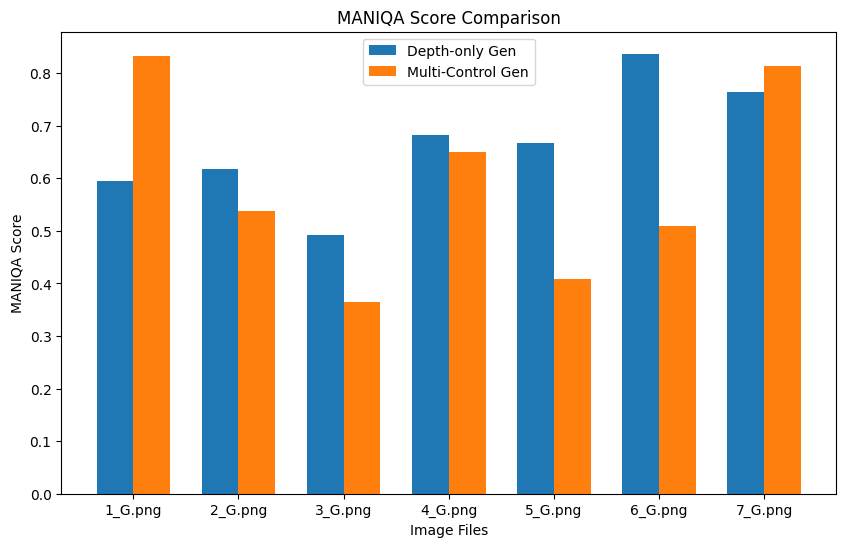

In [12]:
# MANIQA scores collected from above
x = [f"{i}_G.png" for i in range(1, 8)]
maniqa_base = [0.594, 0.618, 0.492, 0.683, 0.668, 0.837, 0.764]
maniqa_gen = [0.833, 0.537, 0.364, 0.650, 0.409, 0.510, 0.814]

# Bar chart
x_indices = np.arange(len(x))
width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x_indices - width / 2, maniqa_base, width, label="Depth-only Gen")
plt.bar(x_indices + width / 2, maniqa_gen, width, label="Multi-Control Gen")

plt.xlabel("Image Files")
plt.ylabel("MANIQA Score")
plt.title("MANIQA Score Comparison")
plt.xticks(x_indices, x)
plt.legend()

# Save the figure
plt.savefig(exp_root / "maniqa_scores.png", bbox_inches="tight")
plt.show()

In [13]:
# Comparing the fidelity of generated depth-maps
res_path_dm = Path("./results/1_experiments/exp1/results")
res_path_multiCN = Path("./results/1_experiments/exp2/results")

jsons_dm = list(res_path_dm.glob("*.json"))
jsons_multiCN = list(res_path_multiCN.glob("*.json"))

jsons_dm.sort(), jsons_multiCN.sort()

(None, None)

In [14]:
for i, (json_dm, json_multiCN) in enumerate(zip(jsons_dm, jsons_multiCN)):
    with open(json_dm, "r") as f:
        dm_metrics = json.load(f)

    with open(json_multiCN, "r") as f:
        multiCN_metrics = json.load(f)

    nrmse_avg_dm = f"{np.array(dm_metrics["NRMSE"], dtype=float).mean():.3f}"
    nrmse_avg_mCN = f"{np.array(multiCN_metrics["NRMSE"], dtype=float).mean():.3f}"

    ssim_avg_dm = f"{np.array(dm_metrics["SSIM"], dtype=float).mean():.3f}"
    ssim_avg_mCN = f"{np.array(multiCN_metrics["SSIM"], dtype=float).mean():.3f}"

    psnr_avg_dm = f"{np.array(dm_metrics["PSNR"], dtype=float).mean():.3f}"
    psnr_avg_mCN = f"{np.array(multiCN_metrics["PSNR"], dtype=float).mean():.3f}"

    # Rich table
    table = Table(title=f"Image: {i + 1}_G.png", padding=(0, 0))
    table.add_column("Metric", justify="center", style="dark_magenta")
    table.add_column("Depth-Map Fidelity", justify="center")

    met_col = Table(show_edge=False)

    for i in ["NRMSE ↓", "SSIM ↑", "PSNR ↑"]:
        met_col.add_row(i)

    met_val = Table(show_edge=False)
    met_val.add_column("Base DM", justify="center", style="orange3")
    met_val.add_column("Generated DM", justify="center", style="green")
    met_val.add_row(*[nrmse_avg_dm, nrmse_avg_mCN])
    met_val.add_row(*[ssim_avg_dm, ssim_avg_mCN])
    met_val.add_row(*[psnr_avg_dm, psnr_avg_mCN])

    table.add_row(met_col, met_val)
    
    print(table)

           Image: 1_G.png           
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃   Depth-Map Fidelity   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Base DM ┃ Generated DM │
│━━━━━━━━━│━━━━━━━━━╇━━━━━━━━━━━━━━│
│ NRMSE ↓ │  0.690  │    0.452     │
│ SSIM ↑  │  0.755  │    0.686     │
│ PSNR ↑  │ 15.835  │    16.891    │
└─────────┴────────────────────────┘

           Image: 2_G.png           
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃   Depth-Map Fidelity   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Base DM ┃ Generated DM │
│━━━━━━━━━│━━━━━━━━━╇━━━━━━━━━━━━━━│
│ NRMSE ↓ │  0.425  │    0.226     │
│ SSIM ↑  │  0.663  │    0.788     │
│ PSNR ↑  │ 14.436  │    21.706    │
└─────────┴────────────────────────┘

           Image: 3_G.png           
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃   Depth-Map Fidelity   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Base DM ┃ Generated DM │
│━━━━━━━━━│━━━━━━━━━╇━━━━━━━━━━━━━━│
│ NRMSE ↓ │  0.276  │    0.215     │
│ SSIM ↑  │  0.502  │    0.876     │
│ PSNR ↑  │ 18.594  │    20.157    │
└─────────┴────────────────────────┘

           Image: 4_G.png           
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃   Depth-Map Fidelity   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Base DM ┃ Generated DM │
│━━━━━━━━━│━━━━━━━━━╇━━━━━━━━━━━━━━│
│ NRMSE ↓ │  0.132  │    0.539     │
│ SSIM ↑  │  0.764  │    0.846     │
│ PSNR ↑  │ 26.675  │    18.504    │
└─────────┴────────────────────────┘

           Image: 5_G.png           
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃   Depth-Map Fidelity   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Base DM ┃ Generated DM │
│━━━━━━━━━│━━━━━━━━━╇━━━━━━━━━━━━━━│
│ NRMSE ↓ │  0.693  │    0.695     │
│ SSIM ↑  │  0.196  │    0.202     │
│ PSNR ↑  │ 11.511  │    11.464    │
└─────────┴────────────────────────┘

           Image: 6_G.png           
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃   Depth-Map Fidelity   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Base DM ┃ Generated DM │
│━━━━━━━━━│━━━━━━━━━╇━━━━━━━━━━━━━━│
│ NRMSE ↓ │  0.363  │    0.237     │
│ SSIM ↑  │  0.792  │    0.905     │
│ PSNR ↑  │ 13.547  │    19.599    │
└─────────┴────────────────────────┘

           Image: 7_G.png           
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric  ┃   Depth-Map Fidelity   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Base DM ┃ Generated DM │
│━━━━━━━━━│━━━━━━━━━╇━━━━━━━━━━━━━━│
│ NRMSE ↓ │  0.184  │    0.347     │
│ SSIM ↑  │  0.891  │    0.655     │
│ PSNR ↑  │ 22.385  │    17.117    │
└─────────┴────────────────────────┘

## Takeaways
* Conditioning SD's generation using the depth-maps alongside some minor preprocessing alone is sufficient to produce good quality images, that adhere to the given depth-maps.
* Adding more controls may produce better images in certain cases, but the corresponding depth-maps do not conform as well to the original depth-maps, in general.
* SD1.5 has a tendency to generate images that are "busy" in terms of textures and details. With more controls (and on experimenting with their relative strengths), it is possible to declutter the generated images, but this comes at the cost of adherence to the depth-maps.
* With multiple controls, the generated images look more natural, with the controls adding more context to the generated images.